In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
wd = "/content/drive/MyDrive/Personal/Apziva"

For this project, I would recommend covering all the basics for modelling. Like EDA, feature engineering, evaluation metrics

This should include, confusion matrix, classification report, feature importance, ROC Curve
And it possible, Predicted Vs Observed charts

###Data Exploration

In [3]:
# Load data and check for NaNs
df = pd.read_csv(f"{wd}/ACME-HappinessSurvey2020.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <BR>
X1 = my order was delivered on time <BR>
X2 = contents of my order was as I expected <br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order <br>
X5 = I am satisfied with my courier <br>
X6 = the app makes ordering easy for me

In [4]:
# Adding extra features
#min score
df["AVG"] = df.loc[:,"X1":"X6"].mean(axis=1)
df["avg_X2_X5"] = df.loc[:,"X2":"X5"].mean(axis=1)
# df["loo_X1"] = df.loc[:,"X2":"X6"].sum(axis=1)
# df["loo_X2"] = df.loc[:,"X1":"X6"].sum(axis=1)
# df["loo_X3"] = df.loc[:,"X1":"X5"].sum(axis=1)
# df["loo_X4"] = df.loc[:,"X1":"X5"].sum(axis=1)
# df["loo_X5"] = df.loc[:,"X1":"X4"].sum(axis=1)
# df["loo_X6"] = df.loc[:,"X1":"X5"].sum(axis=1)
df["user_max"] = df.loc[:,"X1":"X6"].max(axis=1)
df["user_min"] = df.loc[:,"X1":"X6"].min(axis=1)
df.sample(15)

,Y,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5,user_max,user_min
91,1,5,1,3,4,5,5,3.833333,3.25,5,1
49,1,5,1,3,3,4,4,3.333333,2.75,5,1
92,1,5,4,5,5,5,4,4.666667,4.75,5,4
64,1,4,1,3,4,4,4,3.333333,3.00,4,1
6,0,3,1,2,2,1,3,2.000000,1.50,3,1
118,1,4,3,3,4,4,4,3.666667,3.50,4,3
46,1,5,3,3,4,4,5,4.000000,3.50,5,3
22,0,4,3,5,5,5,4,4.333333,4.50,5,3
82,1,4,2,4,4,4,4,3.666667,3.50,4,2
121,1,5,2,3,4,4,3,3.500000,3.25,5,2


**Graphing Function**

In [5]:
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_feature_vs_happiness(df,feature,y_col="Y", y_pred_col=None,
                              levels=(1, 2, 3, 4, 5),
                              show_boxplot=True,figsize=(10, 4)):
    from matplotlib.ticker import PercentFormatter
    # counts and means (fill missing categories with 0)
    counts = df[feature].value_counts().reindex(levels, fill_value=0)
    obs = df.groupby(feature)[y_col].mean().reindex(levels, fill_value=0.0)

    pred = None
    if y_pred_col and y_pred_col in df.columns:
        pred = df.groupby(feature)[y_pred_col].mean().reindex(levels, fill_value=0.0)

    # figure / axes
    if show_boxplot:
        fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=figsize)
    else:
        fig, ax_left = plt.subplots(figsize=(figsize[0]*0.65, figsize[1]))
        ax_right = None

    # LEFT: bars + one twin axis for both lines
    ax_left.bar(counts.index, counts.values)
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel('# of observations')
    ax_left.set_title(f'{feature} vs. customer satisfaction')

    ax_line = ax_left.twinx()
    ax_line.set_ylabel('Percent Happy')
    ax_line.set_ylim(0, 1)
    ax_line.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # plot observed (+ optional predicted) with a tiny loop
    handles = []
    for series, label, color in [(obs, 'Observed', 'red'), (pred, 'Predicted', 'yellow')]:
        if series is None:
            continue
        (ln,) = ax_line.plot(series.index, series.values, marker='o', label=label, color=color)
        handles.append(ln)

    if handles:
        ax_line.legend(handles=handles, loc='upper left')

    # RIGHT: optional boxplot
    if show_boxplot:
        sns.boxplot(x=y_col, y=feature, data=df, ax=ax_right)
        ax_right.set_title(f'Distribution of {feature} by {y_col}')
        ax_right.set_xlabel(f'{y_col} (0: Unhappy, 1: Happy)')

    plt.tight_layout()
    return fig, (ax_left, ax_right)


(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X1 vs. customer satisfaction'}, xlabel='X1', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X1 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X1'>))

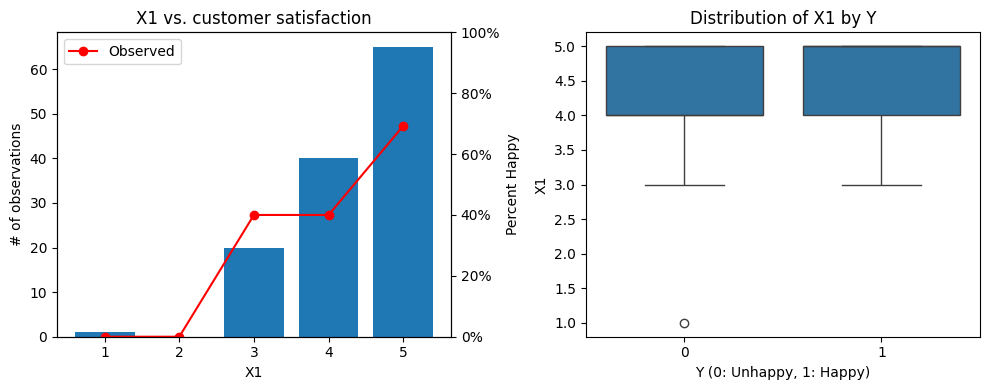

In [6]:
plot_feature_vs_happiness(df, "X1", y_col="Y", y_pred_col=None, show_boxplot=True)

(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X2 vs. customer satisfaction'}, xlabel='X2', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X2 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X2'>))

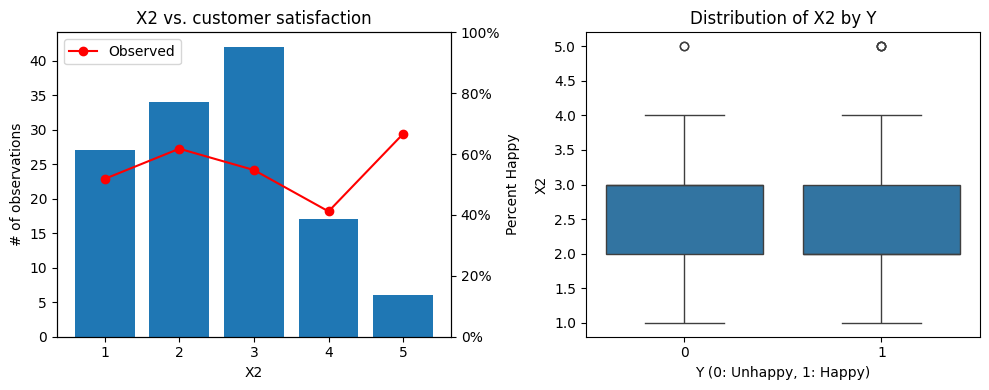

In [7]:
plot_feature_vs_happiness(df, "X2", y_col="Y", y_pred_col=None, show_boxplot=True)

(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X3 vs. customer satisfaction'}, xlabel='X3', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X3 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X3'>))

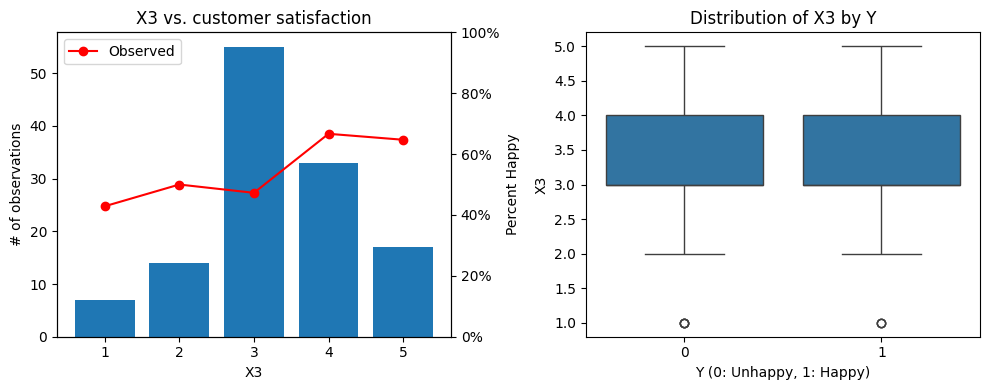

In [8]:
plot_feature_vs_happiness(df, "X3", y_col="Y", y_pred_col=None, show_boxplot=True)

(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X4 vs. customer satisfaction'}, xlabel='X4', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X4 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X4'>))

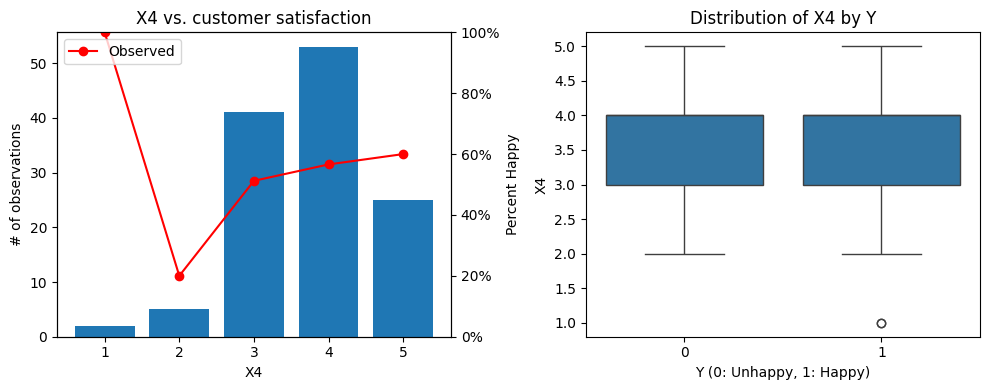

In [9]:
plot_feature_vs_happiness(df, "X4", y_col="Y", y_pred_col=None, show_boxplot=True)

(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X5 vs. customer satisfaction'}, xlabel='X5', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X5 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X5'>))

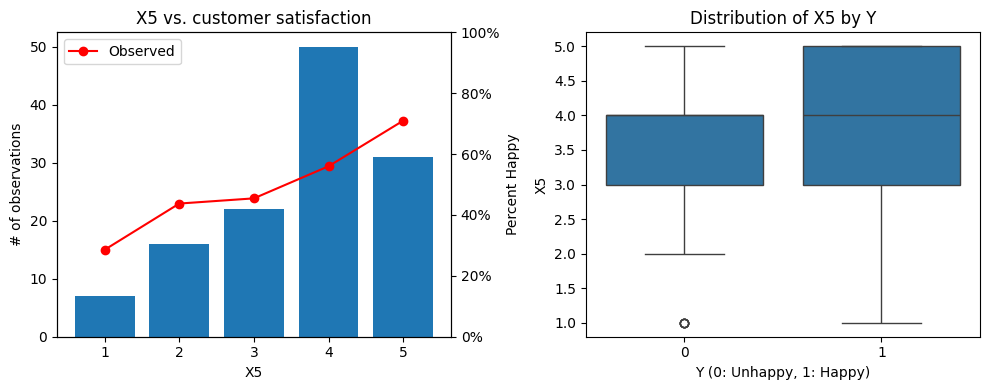

In [10]:
plot_feature_vs_happiness(df, "X5", y_col="Y", y_pred_col=None, show_boxplot=True)

(<Figure size 1000x400 with 3 Axes>,
 (<Axes: title={'center': 'X6 vs. customer satisfaction'}, xlabel='X6', ylabel='# of observations'>,
  <Axes: title={'center': 'Distribution of X6 by Y'}, xlabel='Y (0: Unhappy, 1: Happy)', ylabel='X6'>))

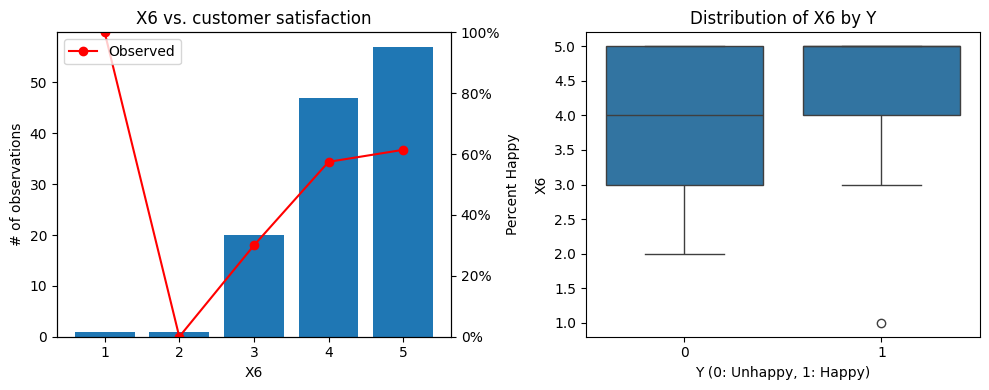

In [11]:
plot_feature_vs_happiness(df, "X6", y_col="Y", y_pred_col=None, show_boxplot=True)

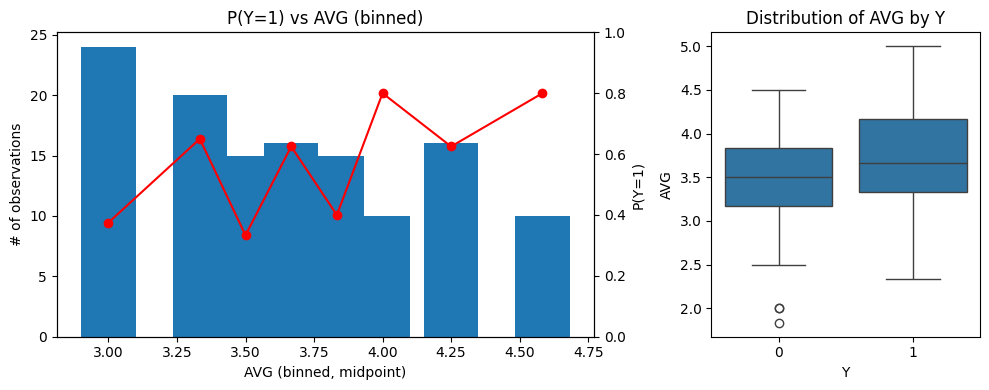

In [ ]:
n_bins = 8
AVG_bin = pd.qcut(df['AVG'], q=n_bins, duplicates='drop')

agg = (df
       .groupby(AVG_bin, observed=True)
       .agg(count=('Y','size'), prop_y1=('Y','mean'),
            x_mid=('AVG', 'median'))
       .reset_index())

# Plot
fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

# Left plot: counts + proportion
ax_left.bar(agg['x_mid'], agg['count'],
            width=np.diff(np.r_[agg['x_mid'], agg['x_mid'].iloc[-1]]).mean())
ax_left.set_xlabel('AVG (binned, midpoint)')
ax_left.set_ylabel('# of observations')

ax2 = ax_left.twinx()
ax2.plot(agg['x_mid'], agg['prop_y1'], marker='o', color='red')
ax2.set_ylabel('P(Y=1)')
ax2.set_ylim(0,1)
ax_left.set_title('P(Y=1) vs AVG (binned)')

# Right plot: boxplot
sns.boxplot(x='Y', y='AVG', data=df, ax=ax_right)
ax_right.set_title('Distribution of AVG by Y')

plt.tight_layout()
plt.show()


###Data Prep

In [14]:
y = df["Y"]
x = df.iloc[:,1:]
x

,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5,user_max,user_min
0,3,3,3,4,2,4,3.166667,3.00,4,2
1,3,2,3,5,4,3,3.333333,3.50,5,2
2,5,3,3,3,3,5,3.666667,3.00,5,3
3,5,4,3,3,3,5,3.833333,3.25,5,3
4,5,4,3,3,3,5,3.833333,3.25,5,3
...,...,...,...,...,...,...,...,...,...,...
121,5,2,3,4,4,3,3.500000,3.25,5,2
122,5,2,3,4,2,5,3.500000,2.75,5,2
123,5,3,3,4,4,5,4.000000,3.50,5,3
124,4,3,3,4,4,5,3.833333,3.50,5,3


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

###XGBoost

In [16]:
# create model instance
bst = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic', num_parallel_tree = 2, subsample = 0.5,reg_lambda=0.5)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_train = bst.predict(X_train)
y_preds_test = bst.predict(X_test)

**Metrics**

Train
Test


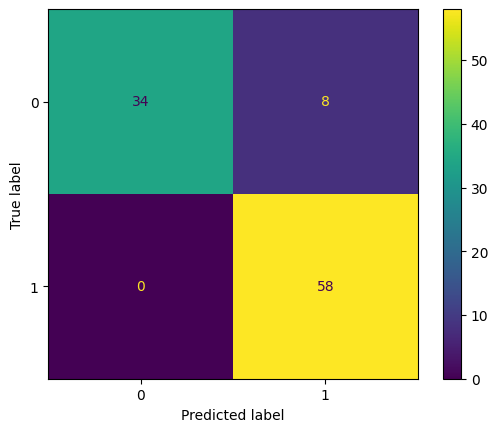

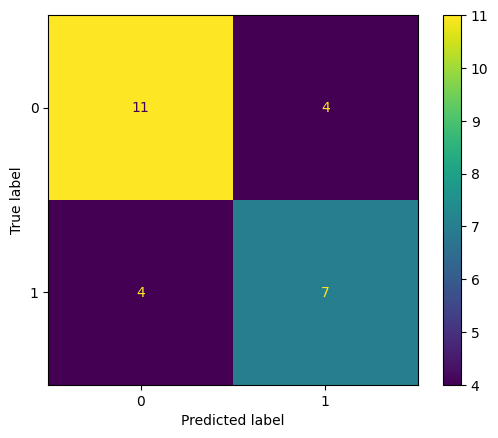

In [ ]:
print("Train")
cm_train = confusion_matrix(y_train, y_pred_train, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bst.classes_)
disp.plot()
print("Test")
cm_test = confusion_matrix(y_test, y_preds_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bst.classes_)
disp_test.plot()
plt.show()

In [ ]:
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        42
           1       0.88      1.00      0.94        58

    accuracy                           0.92       100
   macro avg       0.94      0.90      0.92       100
weighted avg       0.93      0.92      0.92       100

Test Metrics
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.64      0.64      0.64        11

    accuracy                           0.69        26
   macro avg       0.68      0.68      0.68        26
weighted avg       0.69      0.69      0.69        26



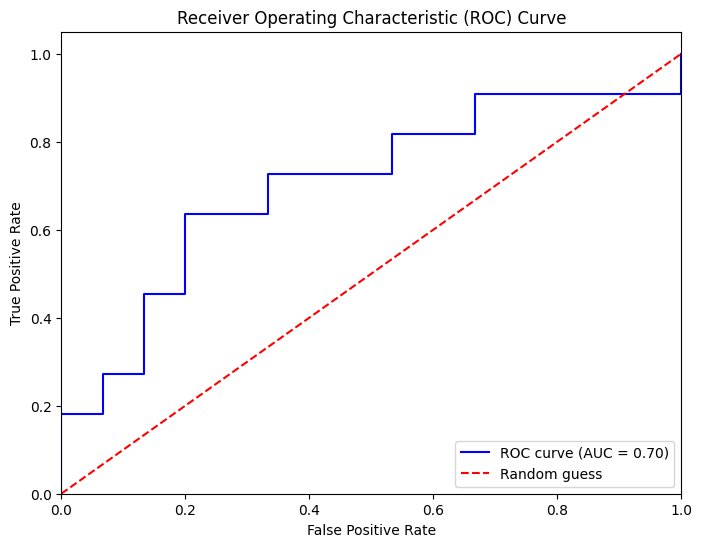

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = bst.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

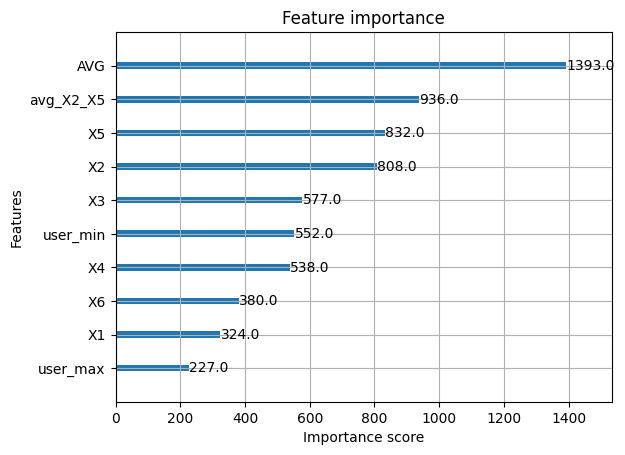

In [ ]:
#AUC/ROC
#Predicted vs. Observed
plot_importance(bst)
plt.show()

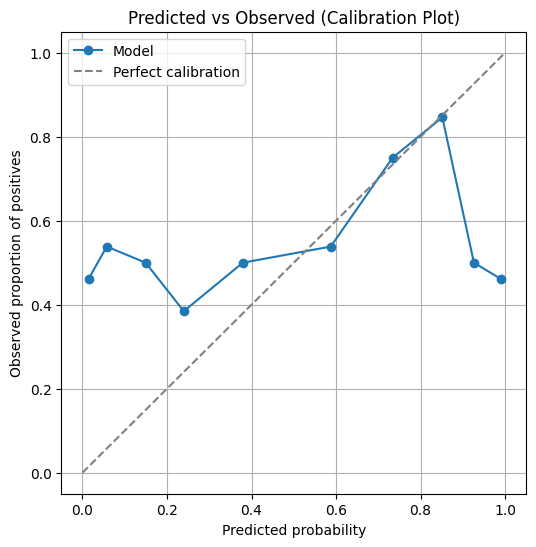

In [ ]:
# 1. Cross-validated probabilities
y_proba = cross_val_predict(bst, x, y, cv=10, method="predict_proba")[:, 1]

# 2. Calibration curve (predicted vs observed)
prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10, strategy='quantile')

# 3. Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed proportion of positives')
plt.title('Predicted vs Observed (Calibration Plot)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
y_pred = cross_val_predict(bst, x, y, cv=10, method="predict")
df['y_pred'] = y_pred

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X1 vs. customer satisfaction'}, xlabel='X1', ylabel='# of observations'>,
  None))

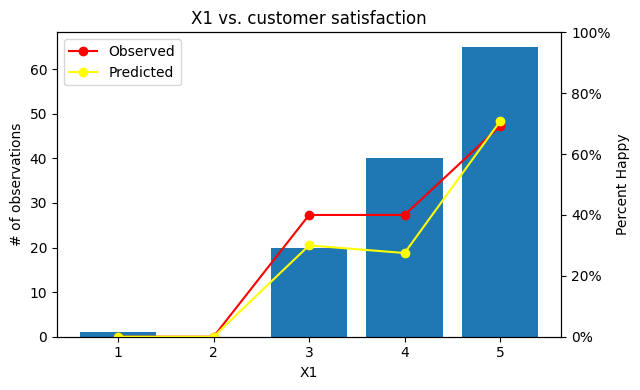

In [19]:
plot_feature_vs_happiness(df, "X1", y_col="Y", y_pred_col="y_pred", show_boxplot=False)

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X2 vs. customer satisfaction'}, xlabel='X2', ylabel='# of observations'>,
  None))

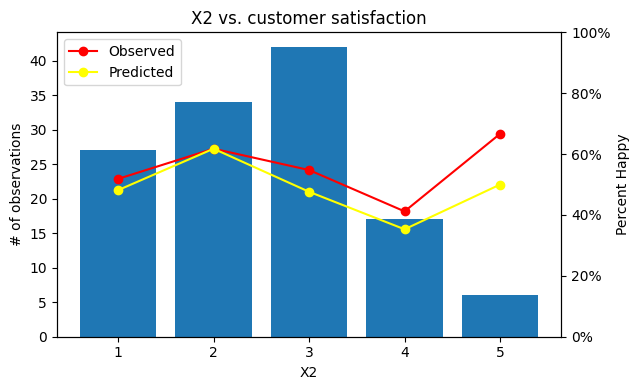

In [20]:
plot_feature_vs_happiness(df, "X2", y_col="Y", y_pred_col="y_pred", show_boxplot=False)

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X3 vs. customer satisfaction'}, xlabel='X3', ylabel='# of observations'>,
  None))

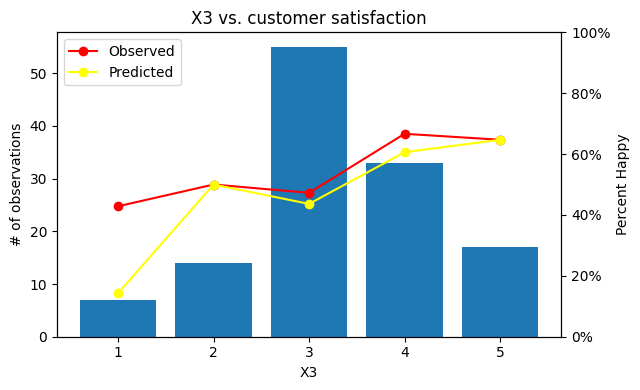

In [21]:
plot_feature_vs_happiness(df, "X3", y_col="Y", y_pred_col="y_pred", show_boxplot=False)

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X4 vs. customer satisfaction'}, xlabel='X4', ylabel='# of observations'>,
  None))

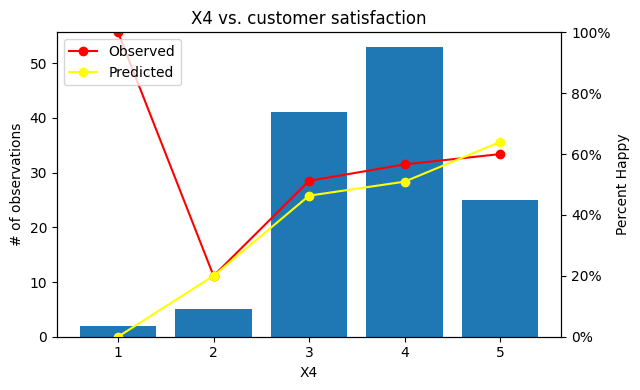

In [22]:
plot_feature_vs_happiness(df, "X4", y_col="Y", y_pred_col="y_pred", show_boxplot=False)

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X5 vs. customer satisfaction'}, xlabel='X5', ylabel='# of observations'>,
  None))

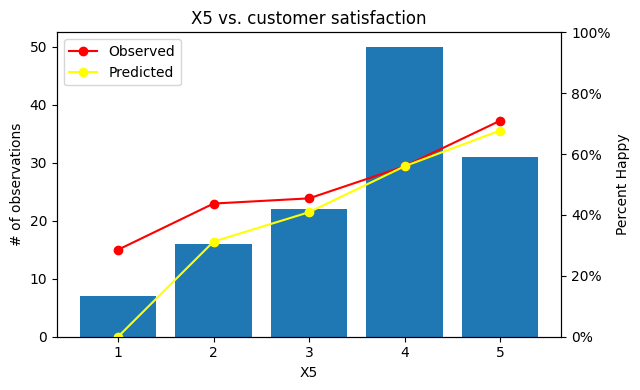

In [23]:
plot_feature_vs_happiness(df, "X5", y_col="Y", y_pred_col="y_pred", show_boxplot=False)

(<Figure size 650x400 with 2 Axes>,
 (<Axes: title={'center': 'X6 vs. customer satisfaction'}, xlabel='X6', ylabel='# of observations'>,
  None))

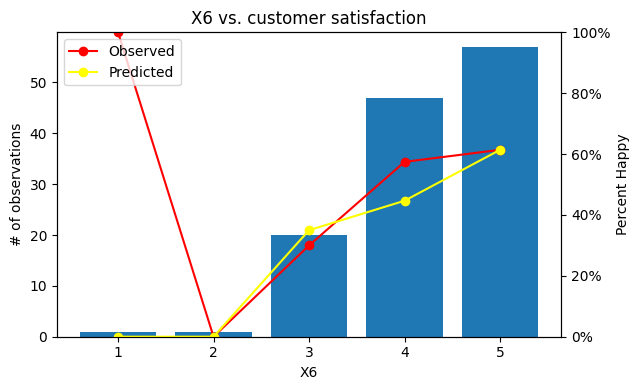

In [24]:
plot_feature_vs_happiness(df, "X6", y_col="Y", y_pred_col="y_pred", show_boxplot=False)